Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 18ms/step - loss: 23.0845 - val_loss: 23.4734
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.8656 - val_loss: 23.2245
Epoch 3/100
8/8 [==============================] - 

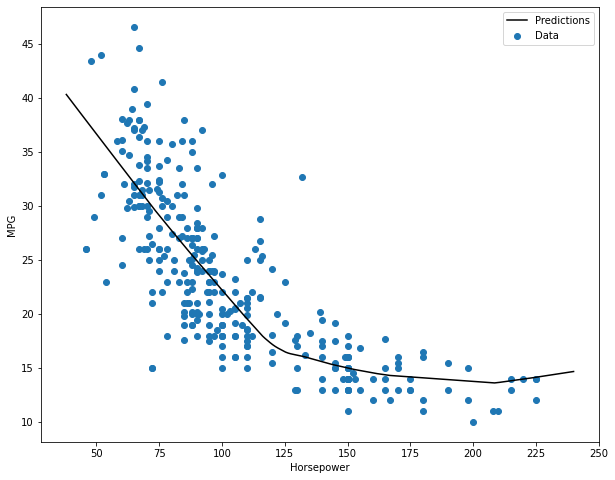

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import urllib

"""#%%"""
#%%
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make numpy printouts easier to read
# This determines the way floating point numbers, arrays and other NumPy objects are displayed.
# precision: number of digits after decimal point. @default = 8
# suppress: if True, always print floating point numbers using fixed notation and in case of numbers = 0 in current precision will print zero
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# -------------------------------------------------- GET DATA SET --------------------------------------------------

# dataset: https://archive.ics.uci.edu/ml/datasets/Auto+MPG
AUTO_MPG_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
AUTO_MPG_PATH = os.path.join('datset', "autoMPG")

# Download dataset
def get_autoMPG_data(autoMPG_url=AUTO_MPG_URL, autoMPG_filePath= AUTO_MPG_PATH):
  os.makedirs(autoMPG_filePath, exist_ok=True)
  filePath = os.path.join(autoMPG_filePath, "autoMPG.csv")
  urllib.request.urlretrieve(autoMPG_url, filePath)

# Uncomment the line to download the fresh dataset.
# get_autoMPG_data()

# -------------------------------------------------- LOAD DATA SET --------------------------------------------------

def load_autoMPG_data(autoMPG_filePath=AUTO_MPG_PATH):
  # Since i downloaded the data , hence loacting the file from local file system.
  column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Accelaration', 'Model Year', 'Origin']

  # After getting the dataset, converting it to csv file format and saving it.
  csv_filePath = os.path.join(autoMPG_filePath, 'autoMPG.csv')

  # names=column_names: as the file has no header, else have to pass header=0, to avoid duplicates
  # na_values='?' : Additional string to consider as NA/NaN value
  # comment = '\t' : Indicates tabs of line should not be parsed. if tabs are found at the begining than it will not parse the entire line.
  # sep=' ': Delimiter to use for seprarting. @default is ','.
  # skipinitialspace = True : Skip spaces after delimiter. @default is False
  return pd.read_csv(csv_filePath, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

autoMPG = load_autoMPG_data()

# -------------------------------------------------- GET DATA SET --------------------------------------------------

# prints the last five columns
# print(autoMPG.tail())

"""
      MPG  Cylinders  Displacement  Horsepower  Weight  Accelaration  Model Year  Origin
393  27.0          4         140.0        86.0  2790.0          15.6          82       1
394  44.0          4          97.0        52.0  2130.0          24.6          82       2
395  32.0          4         135.0        84.0  2295.0          11.6          82       1
396  28.0          4         120.0        79.0  2625.0          18.6          82       1
397  31.0          4         119.0        82.0  2720.0          19.4          82       1
"""

# -------------------------------------------------- CLEAN DATA SET --------------------------------------------------

# ist: We will drop the 'na' datas.
autoMPG = autoMPG.dropna()

# 2nd: The last column "origin" shows a categorical data, where as the rest of the data like Horsepower is numerical.
#      hence we convert it using "one-hot" encoding technique. 
#      one-hot encoding: @source: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
origin = autoMPG.pop('Origin')
autoMPG['USA'] = (origin == 1 ) * 1
autoMPG['Europe'] = (origin == 2) * 1
autoMPG['Japan'] = (origin == 3) * 1

# print(autoMPG.tail())

# ------------------------------------------ CREATE TRAINING and TESTING DATA SET ------------------------------------------

x_train = autoMPG.sample(frac=0.8, random_state=0)
x_test = autoMPG.drop(x_train.index)

# print(autoMPG.shape, x_train.shape, x_test.shape)
"""
(392, 10) (314, 10) (78, 10)
"""
# print(x_train.describe().transpose()) # This gives the statistics of the training data like mean, count min....

"""
              count         mean         std     min      25%     50%      75%     max
MPG           314.0    23.310510    7.728652    10.0    17.00    22.0    28.95    46.6
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0     8.00     8.0
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   265.75   455.0
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   128.00   225.0
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5  3608.00  5140.0
Accelaration  314.0    15.559236    2.789230     8.0    13.80    15.5    17.20    24.8
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0    79.00    82.0
USA           314.0     0.624204    0.485101     0.0     0.00     1.0     1.00     1.0
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0     0.00     1.0
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0     0.00     1.0
"""

# ------------------------------------------ SPLIT FEATURES FROM LABELS ------------------------------------------
x_train_features = x_train.copy()
x_test_features = x_test.copy()

x_train_labels = x_train_features.pop('MPG')
x_test_labels = x_test_features.pop('MPG')

# ------------------------------------------ PLOTTING THE FEATURES USING MATPLOTLIB ------------------------------------------

def plot():
  for feature in x_test_features:
    plt.figure(figsize=(10, 8))
    plt.scatter(x_train_features[feature], x_train_labels, label='Data')
    # if x is not None and y is not None:
    plt.plot(color='k', label='Predictions')
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.legend()

# print(plot())
# -------------------------------------------------- NORMALIZE DATA --------------------------------------------------

# As the data set has different mean, standard deviation and this can confuse our model
# print(x_train.describe().transpose()[['mean', 'std']])
"""
                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Accelaration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712
"""
# Normalization
normalizer = preprocessing.Normalization()

# Before calling we need to adapt it to our data
normalizer.adapt(np.array(x_train_features)) # converting to numpy array as they were initially pandas dataframe
# print(normalizer.mean.numpy())
"""
[   5.478  195.318  104.869 2990.252   15.559   75.898    0.624    0.178
    0.197]
"""

# When the layer is called it returns the input data, with each feature independently normalized:
# (input-mean) / std (standard deviation) -> this means our output has '0' mean and unit variance

first = np.array(x_train_features[:1])
# print('First example:', first)
"""
First example: [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
"""
# print('Normalized: ', normalizer(first).numpy())
"""
Normalized:  [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]
"""

# -------------------------------------------------- REGRESSION --------------------------------------------------
# using for example the Horsepower feature
# Normalise the input Horsepower
# Apply a linear transformation (y=mx+c) to produce 1 output using layers.Dense

feature = 'Horsepower'
single_feature = np.array(x_train_features[feature])
# print(single_feature.shape, x_train_features.shape)
""" (314,) (314, 9) """

# Normalize the Horsepower
single_feature_normalizer = preprocessing.Normalization()

# Adapt to the data (one feature)
single_feature_normalizer.adapt(single_feature)

# Sequential Model
# Lnear model
single_feature_model = keras.models.Sequential([
  single_feature_normalizer,
  layers.Dense(units=1) # units is basically outputs
])
# print(single_feature_model.summary())
"""
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
=================================================================
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________
"""

# -------------------------------------------------- LOSS and OPTIMIZER --------------------------------------------------
loss = keras.losses.MeanAbsoluteError() # we can also use MeanSquaredError (y - y^)
optim = keras.optimizers.Adam(lr=0.1)

# compile model
single_feature_model.compile(optimizer=optim, loss=loss) # we do not provide accuracy as it makes no sense for linear model

# history = single_feature_model.fit(
#   x_train_features[feature],
#   x_train_labels,
#   epochs=100,
#   verbose=1,
#   validation_split=0.2 # Calculate validation result on 20% of the training data (this is used to twig the Hyper parameter)
# )

# -------------------------------------------------- PLOT THE LOSS w.r.t HISTORY --------------------------------------------------
# def plot_loss(history):
#   plt.plot(history.history['loss'], label='loss')
#   plt.plot(history.history['val_loss'], label='val_loss') # val_loss -> validation loss, automatically provided by fit method
#   plt.ylim([0, 25]) # sets the y-axis limits (0, 25)
#   plt.xlabel('Epoch')
#   plt.ylabel('Error [MPG]')
#   plt.legend() # A legend is an area describing the elements of the graph
#   plt.grid(True)

# plot_loss(history)

# -------------------------------------------------- Evaluate the model --------------------------------------------------
# single_feature_model.evaluate(
#   x_test_features[feature],
#   x_test_labels,
#   verbose=1
# )

""" 3/3 [==============================] - 0s 436us/step - loss: 3.6494 """

# -------------------------------------------------- PREDICT and PLOT --------------------------------------------------
# creating a random sample
range_min = np.min(x_test_features[feature]) - 10
range_max = np.max(x_test_features[feature]) + 10
x = tf.linspace(range_min, range_max, 200) # 200 is for creating an evenly spaced values begining at start ,i.e, range_min
y = single_feature_model.predict(x)

def plot_predict_evaluate(feature, x=None, y=None):
  plt.figure(figsize=(10, 8))
  plt.scatter(x_train_features[feature], x_train_labels, label='Data')
  if x is not None and y is not None:
    plt.plot(x,y, color='k', label='Predictions')
  plt.xlabel(feature)
  plt.ylabel('MPG')
  plt.legend()

# plot_predict_evaluate(feature, x,y)


#########################################################***********#########################################################
# --------------------- Now converting our linear regression model to a DEEP NEURAL network ------------------------

dnn_model = keras.Sequential([
  single_feature_normalizer,
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1) # one output (one class)
])

# Compile with loss and Adam optimizer
dnn_model.compile(
  loss=loss,
  optimizer=tf.keras.optimizers.Adam(0.001)
)
dnn_model.summary()
"""
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
=================================================================
Total params: 4,356 # A lot ore params to train
Trainable params: 4,353
Non-trainable params: 3
"""

dnn_model.fit(
  x_train_features[feature], # feature is "Horsepower"
  x_train_labels,
  validation_split=0.2,
  verbose=1,
  epochs=100
)

# Evaluate our model
dnn_model.evaluate(x_test_features[feature], x_test_labels, verbose=1)
""" 3/3 [==============================] - 0s 501us/step - loss: 2.9320 """ # here its below 3 compared to previous model.

# Predict and plot
x = tf.linspace(range_min, range_max, 200)
y = dnn_model.predict(x)

plot_predict_evaluate(feature, x, y)
